In [1]:
import pandas as pd
import numpy as np
import json
from peptides import Peptide
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import wandb
import joblib

# --- Logging ---
def log(msg):
    print(f"[INFO] {msg}")

# --- W&B initialisieren ---
dataset_name = "beta_allele"
wandb.init(
    project="dataset-allele",
    entity="ba_cancerimmunotherapy",
    job_type="physchem_selection",
    name="feature_selection_run"
)

# --- Artifact herunterladen ---
artifact = wandb.use_artifact("ba_cancerimmunotherapy/dataset-allele/beta_allele:latest")
data_dir = artifact.download(f"./WnB_Experiments_Datasets/{dataset_name}")

# --- Dateipfade definieren ---
path_beta_train = f"{data_dir}/allele/train.tsv"

# --- Daten laden ---
log("Lade Datensätze...")
df_beta_train = pd.read_csv(path_beta_train, sep="\t", index_col=False)
log(f"Datensätze geladen: {len(df_beta_train)} Einträge")

# --- Relevante Spalten extrahieren ---
df_physchem = df_beta_train[["TRB_CDR3", "Epitope", "Binding"]].dropna()
log(f"Gefiltert: {len(df_physchem)} Einträge mit TRB_CDR3, Epitope und Binding")

# --- Deskriptoren extrahieren ---
def get_descriptors(seq):
    try:
        return Peptide(seq).descriptors()
    except:
        return {}

log("Extrahiere Deskriptoren für TCR...")
tcr_desc = df_physchem["TRB_CDR3"].apply(get_descriptors)
log("Extrahiere Deskriptoren für Epitope...")
epi_desc = df_physchem["Epitope"].apply(get_descriptors)

# --- Kombinieren & Label anhängen ---
tcr_df = pd.DataFrame(tcr_desc.tolist()).add_prefix("tcr_")
epi_df = pd.DataFrame(epi_desc.tolist()).add_prefix("epi_")
desc_df = pd.concat([tcr_df, epi_df], axis=1)
desc_df["label"] = df_physchem["Binding"].values

# --- Feature-Matrix & Zielvariable ---
X = desc_df.drop(columns=["label"])
y = desc_df["label"]

# --- Skalieren ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Feature Importance berechnen ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = list(importances.sort_values(ascending=False).index)

# --- Speichern ---
with open("selected_physchem_features.json", "w") as f:
    json.dump(selected_features, f, indent=2)

joblib.dump(scaler, "physchem_scaler.pkl")
print("\n✅ Scaler gespeichert als: physchem_scaler.pkl")

print("\nTop Features (nach Importance sortiert):")
print(importances.sort_values(ascending=False).head(30))
print("\n✅ Gespeichert als: selected_physchem_features.json")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arina-frohofer (ba_cancerimmunotherapy). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact beta_allele:latest, 1316.87MB. 93 files... 
wandb:   93 of 93 files downloaded.  
Done. 0:0:1.4


[INFO] Lade Datensätze...
[INFO] Datensätze geladen: 757732 Einträge
[INFO] Gefiltert: 757732 Einträge mit TRB_CDR3, Epitope und Binding
[INFO] Extrahiere Deskriptoren für TCR...
[INFO] Extrahiere Deskriptoren für Epitope...

✅ Scaler gespeichert als: physchem_scaler.pkl

Top Features (nach Importance sortiert):
tcr_BLOSUM9     0.009063
tcr_KF10        0.008353
epi_SVGER2      0.008312
tcr_BLOSUM5     0.008109
tcr_BLOSUM10    0.008092
tcr_VHSE5       0.007966
tcr_ProtFP8     0.007763
tcr_KF7         0.007739
tcr_KF3         0.007692
tcr_AF3         0.007684
tcr_KF5         0.007675
tcr_F1          0.007635
tcr_ProtFP7     0.007630
tcr_PRIN3       0.007629
tcr_BLOSUM4     0.007612
tcr_MSWHIM2     0.007593
tcr_Z5          0.007589
tcr_KF9         0.007576
tcr_KF8         0.007563
tcr_ST7         0.007529
tcr_VHSE8       0.007520
tcr_SVGER3      0.007480
tcr_KF6         0.007479
tcr_E4          0.007472
tcr_F5          0.007472
tcr_SVGER6      0.007458
tcr_F6          0.007448
tcr_BLOSUM6

In [2]:
import os
import pandas as pd
import numpy as np
import json
import h5py
import wandb
import importlib
import joblib
import ple_embedding as pe
# importlib.reload(pe)

# --- Logging ---
def log(msg):
    print(f"[INFO] {msg}")

# --- W&B initialisieren ---
dataset_name = "beta_allele"
wandb.init(
    project="dataset-allele",
    entity="ba_cancerimmunotherapy",
    job_type="physchem_encoding",
    name="descriptor_feature_extraction"
)

# --- Artifact herunterladen ---
artifact = wandb.use_artifact("ba_cancerimmunotherapy/dataset-allele/beta_allele:latest")
data_dir = artifact.download(f"./WnB_Experiments_Datasets/{dataset_name}")

# --- Dateipfade definieren ---
path_beta_test = f"{data_dir}/allele/test.tsv"
path_beta_validation = f"{data_dir}/allele/validation.tsv"
path_beta_train = f"{data_dir}/allele/train.tsv"

# --- Daten laden ---
log("Lade Datensätze...")
df_beta_test = pd.read_csv(path_beta_test, sep="\t", index_col=False)
df_beta_validation = pd.read_csv(path_beta_validation, sep="\t", index_col=False)
df_beta_train = pd.read_csv(path_beta_train, sep="\t", index_col=False)
df_beta = pd.concat([df_beta_test, df_beta_validation, df_beta_train])
log(f"Datensätze geladen: {len(df_beta)} Einträge")

# --- Relevante Spalten extrahieren ---
df_physchem = df_beta[["TRB_CDR3", "Epitope", "Binding"]].dropna()
log(f"Gefiltert: {len(df_physchem)} Einträge mit TRB_CDR3, Epitope und Binding")

# --- Features laden & trennen ---
with open("selected_physchem_features.json") as f:
    all_features = json.load(f)

tcr_features = [f.replace("tcr_", "") for f in all_features if f.startswith("tcr_")]
epi_features = [f.replace("epi_", "") for f in all_features if f.startswith("epi_")]

# --- Scaler laden ---
log("Lade Scaler aus Training...")
scaler = joblib.load("physchem_scaler.pkl")

# --- Feature-Encoding ---
log("Berechne Deskriptor-Features für TCR...")
df_physchem["tcr_encoded"] = df_physchem["TRB_CDR3"].apply(lambda s: pe.encode_descriptor_sequence(s, tcr_features))

log("Berechne Deskriptor-Features für Epitope...")
df_physchem["epi_encoded"] = df_physchem["Epitope"].apply(lambda s: pe.encode_descriptor_sequence(s, epi_features))

# --- Zu Matrix zusammenfügen ---
log("Kombiniere Feature-Vektoren und skaliere mit Training-Scaler...")
tcr_arr = np.stack(df_physchem["tcr_encoded"].to_numpy())
epi_arr = np.stack(df_physchem["epi_encoded"].to_numpy())

# Kombinieren & Skalieren
X_encoded = np.concatenate([tcr_arr, epi_arr], axis=1)
X_scaled = scaler.transform(X_encoded)

# Wieder aufteilen
num_tcr = tcr_arr.shape[1]
tcr_scaled = X_scaled[:, :num_tcr]
epi_scaled = X_scaled[:, num_tcr:]
binding_arr = df_physchem["Binding"].to_numpy()

# --- physchem_index hinzufügen ---
df_physchem["physchem_index"] = np.arange(len(df_physchem))

# --- Mapping-Datei speichern ---
mapping_path = "../../../data/physico/descriptor_encoded_physchem_mapping.tsv"
df_physchem[["TRB_CDR3", "Epitope", "physchem_index"]].to_csv(mapping_path, sep="\t", index=False)
log(f"Mapping gespeichert unter: {mapping_path}")

# --- HDF5 speichern ---
output_path = "../../../data/physico/descriptor_encoded_physchem.h5"
log(f"Speichere vorbereiteten DataFrame nach: {output_path}")
with h5py.File(output_path, "w") as h5f:
    h5f.create_dataset("tcr_encoded", data=tcr_scaled)
    h5f.create_dataset("epi_encoded", data=epi_scaled)
    h5f.create_dataset("binding", data=binding_arr)
print(f"[INFO] Gespeichert als HDF5 unter: {output_path}")

# --- Abschließen ---
log("✅ Alles abgeschlossen und gespeichert!")
wandb.finish()

2025-05-12 06:54:10.393660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 06:54:10.951659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 06:54:11.417164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747032851.741610   19669 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747032851.833176   19669 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747032852.668879   19669 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

wandb: Downloading large artifact beta_allele:latest, 1316.87MB. 93 files... 
wandb:   93 of 93 files downloaded.  
Done. 0:0:1.3


[INFO] Lade Datensätze...


/tmp/ipykernel_19669/4110575145.py:37: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_beta_validation = pd.read_csv(path_beta_validation, sep="\t", index_col=False)


[INFO] Datensätze geladen: 972435 Einträge
[INFO] Gefiltert: 972435 Einträge mit TRB_CDR3, Epitope und Binding
[INFO] Lade Scaler aus Training...
[INFO] Berechne Deskriptor-Features für TCR...
[INFO] Berechne Deskriptor-Features für Epitope...
[INFO] Kombiniere Feature-Vektoren und skaliere mit Training-Scaler...


/home/ubuntu/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[INFO] Mapping gespeichert unter: ../../../data/physico/descriptor_encoded_physchem_mapping.tsv
[INFO] Speichere vorbereiteten DataFrame nach: ../../../data/physico/descriptor_encoded_physchem.h5
[INFO] Gespeichert als HDF5 unter: ../../../data/physico/descriptor_encoded_physchem.h5
[INFO] ✅ Alles abgeschlossen und gespeichert!


In [3]:
import json

with open("selected_physchem_features.json", "r") as f:
    features = json.load(f)

print("✅ Geladene Features:")
for i, feat in enumerate(features, 1):
    print(f"{i:2d}. {feat}")


✅ Geladene Features:
 1. tcr_BLOSUM9
 2. tcr_KF10
 3. epi_SVGER2
 4. tcr_BLOSUM5
 5. tcr_BLOSUM10
 6. tcr_VHSE5
 7. tcr_ProtFP8
 8. tcr_KF7
 9. tcr_KF3
10. tcr_AF3
11. tcr_KF5
12. tcr_F1
13. tcr_ProtFP7
14. tcr_PRIN3
15. tcr_BLOSUM4
16. tcr_MSWHIM2
17. tcr_Z5
18. tcr_KF9
19. tcr_KF8
20. tcr_ST7
21. tcr_VHSE8
22. tcr_SVGER3
23. tcr_KF6
24. tcr_E4
25. tcr_F5
26. tcr_SVGER6
27. tcr_F6
28. tcr_BLOSUM6
29. tcr_ProtFP4
30. tcr_ProtFP5
31. tcr_SVGER2
32. tcr_AF5
33. tcr_Z4
34. tcr_SVGER9
35. tcr_Z3
36. tcr_SV4
37. tcr_SVGER4
38. tcr_BLOSUM8
39. tcr_E5
40. tcr_PP3
41. tcr_VHSE7
42. tcr_SV1
43. tcr_SVGER11
44. tcr_SVGER10
45. tcr_T3
46. tcr_ST4
47. tcr_BLOSUM7
48. tcr_VSTPV4
49. tcr_ST3
50. tcr_ProtFP6
51. tcr_SVGER5
52. tcr_SVGER1
53. tcr_VSTPV5
54. tcr_SV3
55. tcr_ProtFP3
56. tcr_VSTPV2
57. tcr_ST8
58. tcr_VHSE6
59. tcr_ST5
60. tcr_ST2
61. tcr_ProtFP1
62. tcr_VHSE4
63. tcr_F4
64. tcr_E3
65. tcr_SVGER8
66. tcr_MSWHIM3
67. tcr_AF2
68. tcr_KF1
69. tcr_BLOSUM1
70. tcr_E1
71. tcr_PRIN1
72. tcr_AF1

In [4]:
cat selected_physchem_features.json | jq length

204


wandb: Downloading large artifact beta_allele:latest, 1001.05MB. 46 files... 
wandb:   46 of 46 files downloaded.  
Done. 0:0:2.0
/tmp/ipykernel_47990/3198741877.py:42: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_val = pd.read_csv(path_beta_validation, sep="\t", index_col=False)


[INFO] Berechne physikochemische Deskriptoren...
[INFO] Trainiere Random Forest...

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    165597
           1       0.78      0.50      0.61     33019

    accuracy                           0.89    198616
   macro avg       0.84      0.74      0.77    198616
weighted avg       0.89      0.89      0.88    198616

ROC AUC: 0.9102


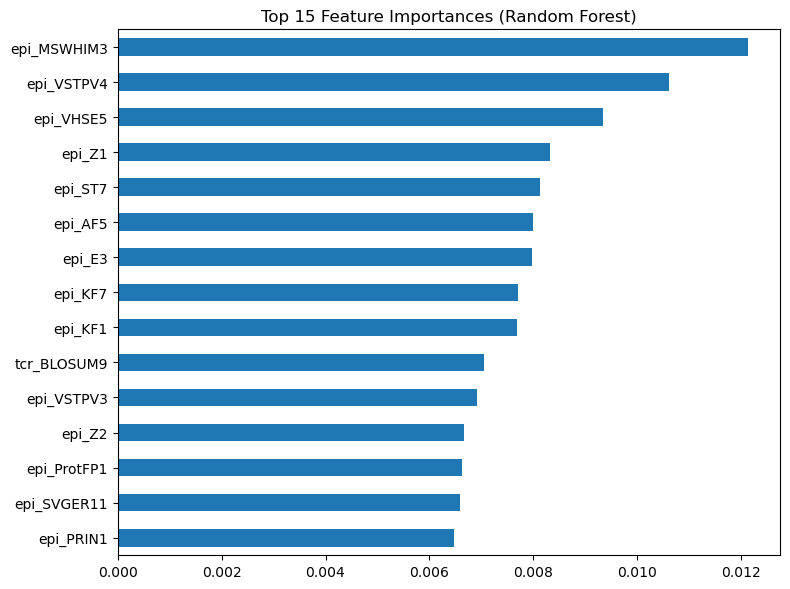

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

import wandb
from ple_embedding import encode_descriptor_sequence  # Importiere deine Encoding-Funktion hier

# === W&B initialisieren ===
wandb.init(
    project="dataset-allele",
    entity="ba_cancerimmunotherapy",
    job_type="physchem_rf_test",
    name="physchem_rf_binding_prediction"
)

# === Lade Top-N Features ===
with open("selected_physchem_features.json", "r") as f:
    features = json.load(f)

tcr_features = [f.replace("tcr_", "") for f in features if f.startswith("tcr_")]
epi_features = [f.replace("epi_", "") for f in features if f.startswith("epi_")]

# === Lade Datensätze aus Artifact ===
dataset_name = "beta_allele"
artifact = wandb.use_artifact("ba_cancerimmunotherapy/dataset-allele/beta_allele:latest")
data_dir = artifact.download(f"./WnB_Experiments_Datasets/{dataset_name}")

# === CSV-Pfade ===
path_beta_test = f"{data_dir}/allele/test.tsv"
path_beta_validation = f"{data_dir}/allele/validation.tsv"
path_beta_train = f"{data_dir}/allele/train.tsv"

# === Lade und kombiniere Daten ===
df_test = pd.read_csv(path_beta_test, sep="\t", index_col=False)
df_val = pd.read_csv(path_beta_validation, sep="\t", index_col=False)
df_train = pd.read_csv(path_beta_train, sep="\t", index_col=False)
df_beta = pd.concat([df_test, df_val, df_train])

df_physchem = df_beta[["TRB_CDR3", "Epitope", "Binding"]].dropna()

# === Berechne physikochemische Features ===
print("[INFO] Berechne physikochemische Deskriptoren...")
df_physchem["tcr_encoded"] = df_physchem["TRB_CDR3"].apply(lambda s: encode_descriptor_sequence(s, tcr_features))
df_physchem["epi_encoded"] = df_physchem["Epitope"].apply(lambda s: encode_descriptor_sequence(s, epi_features))

# === Kombiniere zu X und y ===
X = np.hstack([
    df_physchem["tcr_encoded"].to_list(),
    df_physchem["epi_encoded"].to_list()
])
y = df_physchem["Binding"].values

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Skalieren ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Trainiere Random Forest ===
print("[INFO] Trainiere Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# === Vorhersage & Bewertung ===
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# === Feature-Importanz plotten ===
importances = rf.feature_importances_
feature_names = [f"tcr_{f}" for f in tcr_features] + [f"epi_{f}" for f in epi_features]
top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

wandb.finish()